# Background

In this notebook, covariate shift and prior probability shift will be discovered.

For sake of simplicity, the definitions of the shifts are:

1. <b>Covariate shift:</b> Shift in independent variables.
2. <b>Prior probability shift:</b> Shift in target variable.


From the result, we can basically see that removing the covariate and prior probability shifts help to reduce the MAE.

In [1]:
import os

import pandas as pd
import numpy as np
from numpy.random import seed
from numpy.random import randint
from numpy import mean
from numpy import median
from numpy import percentile
import math 

from numpy.random import seed
from numpy.random import randn
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
from fancyimpute import IterativeImputer
from yellowbrick.features import FeatureImportances

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import GenericUnivariateSelect, f_regression, mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer

pd.set_option('display.max_columns', 500)

## Load data

About Data: Japan Real Estates Prices

Reference: https://www.kaggle.com/nishiodens/japan-real-estate-transaction-prices

Choose prefecture = Tokyo, which is stored in 13.csv.

In [2]:
file_name_list = [str('{:02.0f}'.format(x)) if x in range(1,10) else str(x) for x in range(1,48)]

In [3]:
ROOT_DIR = '~/Desktop/learning/general_statistics/statistic_learning/practice/dataset/trade_prices'
READ_ALL = False

if READ_ALL:

    for file_name in file_name_list:

        read_path = os.path.join(ROOT_DIR, f'{file_name}.csv')

        data = pd.read_csv(read_path)
        
else:
    
    # get data only in precture Tokyo
    read_path_tokyo = os.path.join(ROOT_DIR, '13.csv')
    
    df_tokyo = pd.read_csv(read_path_tokyo)

In [4]:
df_tokyo.head()

,No,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,FloorPlan,Area,AreaIsGreaterFlag,UnitPrice,PricePerTsubo,LandShape,Frontage,FrontageIsGreaterFlag,TotalFloorArea,TotalFloorAreaIsGreaterFlag,BuildingYear,PrewarBuilding,Structure,Use,Purpose,Direction,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks
0,1,"Pre-owned Condominiums, etc.",NaN,13101,Tokyo,Chiyoda Ward,Iidabashi,Iidabashi,4,4.0,4.0,40000000,1LDK,30,0,NaN,NaN,NaN,NaN,False,NaN,0,2013.0,0,RC,House,House,NaN,NaN,NaN,Commercial Zone,80.0,500.0,3rd quarter 2019,2019,3,Not yet,NaN
1,2,"Pre-owned Condominiums, etc.",NaN,13101,Tokyo,Chiyoda Ward,Iidabashi,Iidabashi,4,4.0,4.0,130000000,3LDK,80,0,NaN,NaN,NaN,NaN,False,NaN,0,2007.0,0,RC,NaN,Other,NaN,NaN,NaN,Commercial Zone,80.0,500.0,3rd quarter 2019,2019,3,Done,NaN
2,3,Residential Land(Land and Building),Commercial Area,13101,Tokyo,Chiyoda Ward,Iidabashi,Iidabashi,2,2.0,2.0,400000000,NaN,110,0,NaN,NaN,Trapezoidal Shaped,9.0,False,260.0,0,2018.0,0,S,"Office, Shop",Shop,Northwest,Ward Road,4.0,Commercial Zone,80.0,500.0,2nd quarter 2019,2019,2,NaN,NaN
3,4,Residential Land(Land and Building),Commercial Area,13101,Tokyo,Chiyoda Ward,Iidabashi,Iidabashi,1,1.0,1.0,180000000,NaN,50,0,NaN,NaN,Rectangular Shaped,5.2,False,260.0,0,1976.0,0,RC,"Housing Complex, Office",NaN,Southwest,Tokyo Metropolitan Road,27.0,Commercial Zone,80.0,700.0,2nd quarter 2019,2019,2,NaN,NaN
4,5,"Pre-owned Condominiums, etc.",NaN,13101,Tokyo,Chiyoda Ward,Iidabashi,Iidabashi,4,4.0,4.0,100000000,2LDK,65,0,NaN,NaN,NaN,NaN,False,NaN,0,2007.0,0,RC,House,House,NaN,NaN,NaN,Commercial Zone,80.0,500.0,2nd quarter 2019,2019,2,Done,NaN


In [5]:
df_tokyo.drop('No',axis=1,inplace=True)

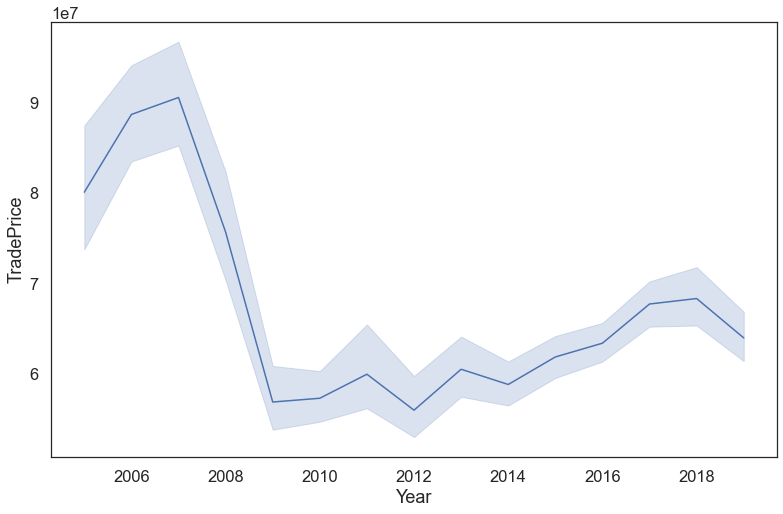

In [6]:
sns.set(font_scale = 1.5)
sns.set_style('white')

plt.figure(figsize=(13,8))

sns.lineplot(data=df_tokyo, x='Year', y='TradePrice')
plt.xlabel('Year', fontsize=18)
plt.ylabel('TradePrice', fontsize=18)

plt.show()

## Data understanding

### Basic understanding

In [7]:
print('Total records:', len(df_tokyo))
print('Total variables:', len(df_tokyo.columns))
print('Percentage of null in each column:')
round(df_tokyo.isnull().sum()/len(df_tokyo)*100,2)

Total records: 406575
Total variables: 37
Percentage of null in each column:


Type                            0.00
Region                         45.47
MunicipalityCode                0.00
Prefecture                      0.00
Municipality                    0.00
DistrictName                    0.06
NearestStation                  0.43
TimeToNearestStation            2.54
MinTimeToNearestStation         2.54
MaxTimeToNearestStation         2.58
TradePrice                      0.00
FloorPlan                      56.19
Area                            0.00
AreaIsGreaterFlag               0.00
UnitPrice                      80.45
PricePerTsubo                  80.45
LandShape                      45.57
Frontage                       50.10
FrontageIsGreaterFlag           0.00
TotalFloorArea                 66.45
TotalFloorAreaIsGreaterFlag     0.00
BuildingYear                   22.70
PrewarBuilding                  0.00
Structure                      21.70
Use                            24.08
Purpose                        61.20
Direction                      45.57
C

In [8]:
for column in df_tokyo.columns:
    print(f'Total unique values in {column}:',len(df_tokyo[column].unique()))
    print(column, ':', df_tokyo[column].unique(),'\n')

Total unique values in Type: 5
Type : ['Pre-owned Condominiums, etc.' 'Residential Land(Land and Building)'
 'Residential Land(Land Only)' 'Forest Land' 'Agricultural Land'] 

Total unique values in Region: 5
Region : [nan 'Commercial Area' 'Residential Area' 'Industrial Area'
 'Potential Residential Area'] 

Total unique values in MunicipalityCode: 59
MunicipalityCode : [13101 13102 13103 13104 13105 13106 13107 13108 13109 13110 13111 13112
 13113 13114 13115 13116 13117 13118 13119 13120 13121 13122 13123 13201
 13202 13203 13204 13205 13206 13207 13208 13209 13210 13211 13212 13213
 13214 13215 13218 13219 13220 13221 13222 13223 13224 13225 13227 13228
 13229 13303 13305 13307 13308 13361 13363 13364 13381 13401 13421] 

Total unique values in Prefecture: 1
Prefecture : ['Tokyo'] 

Total unique values in Municipality: 59
Municipality : ['Chiyoda Ward' 'Chuo Ward' 'Minato Ward' 'Shinjuku Ward' 'Bunkyo Ward'
 'Taito Ward' 'Sumida Ward' 'Koto Ward' 'Shinagawa Ward' 'Meguro Ward'
 'Ot

Total unique values in TimeToNearestStation: 35
TimeToNearestStation : ['4' '2' '1' nan '3' '5' '8' '7' '6' '0' '11' '10' '9' '12' '30-60minutes'
 '13' '14' '16' '15' '19' '20' '18' '21' '2H-' '1H30-2H' '17' '22' '29'
 '1H-1H30' '23' '25' '28' '26' '24' '27'] 

Total unique values in MinTimeToNearestStation: 35
MinTimeToNearestStation : [  4.   2.   1.  nan   3.   5.   8.   7.   6.   0.  11.  10.   9.  12.
  30.  13.  14.  16.  15.  19.  20.  18.  21. 120.  90.  17.  22.  29.
  60.  23.  25.  28.  26.  24.  27.] 

Total unique values in MaxTimeToNearestStation: 34
MaxTimeToNearestStation : [  4.   2.   1.  nan   3.   5.   8.   7.   6.   0.  11.  10.   9.  12.
  60.  13.  14.  16.  15.  19.  20.  18.  21. 120.  17.  22.  29.  90.
  23.  25.  28.  26.  24.  27.] 

Total unique values in TradePrice: 504
TradePrice : [   40000000   130000000   400000000   180000000   100000000   120000000
    24000000    13000000   250000000    22000000    69000000    21000000
    81000000    45000000    6

LandShape : [nan 'Trapezoidal Shaped' 'Rectangular Shaped' 'Semi-rectangular Shaped'
 'Semi-trapezoidal Shaped' 'Semi-square Shaped' 'Irregular Shaped'
 'Semi-shaped' 'Flag-shaped etc.' 'Square Shaped'] 

Total unique values in Frontage: 478
Frontage : [ nan  9.   5.2  6.5  6.8 13.   6.4  9.4 15.   7.   6.7 12.  35.   8.
 28.  22.6  3.5 13.1 10.4 10.  14.7  3.  13.5  2.5  4.2 13.2  6.3  5.
  9.5  6.   4.6 19.   7.5  4.5  7.1 10.5 14.6  4.   8.5 16.   5.5 11.5
 15.6 10.8  4.3 11.   6.1 14.8  8.2  9.9 11.7 18.   7.7 12.7  3.8  7.9
  5.7  3.7 18.5 20.3  5.6 11.6 20.   9.3 13.3  6.2 12.5 10.1  8.7 22.2
 16.5 30.   4.7  9.1 25.  11.3  7.2 17.  14.  17.5 10.6  5.8  7.8 14.5
 45.   4.1 26.   9.2 14.4 24.  21.5 31.6 41.5  2.4 31.   9.8  7.3 11.8
 11.1  9.7 22.5 21.   1.9  6.6  8.1 12.6 12.3 23.  32.  22.  40.  20.8
 15.5 11.4  4.8 19.5 27.  23.5  5.1  4.4  3.9 18.3 12.2  5.4  8.6  2.7
  9.6 18.1  6.9 14.2 29.   5.9  7.4 24.5 15.4 10.3 23.6  8.4  8.8 38.5
  3.6 14.1 36.   7.6  8.9 12.9  5.3  4.

Direction : [nan 'Northwest' 'Southwest' 'South' 'Northeast' 'East' 'Southeast' 'West'
 'North' 'No facing road'] 

Total unique values in Classification: 15
Classification : [nan 'Ward Road' 'Tokyo Metropolitan Road' 'Private Road' 'Town Road'
 'National Highway' 'Road' 'Village Road' 'Agricultural Road'
 'Forest Road' 'City Road' 'Access Road' 'Prefectural Road'
 'Hokkaido Prefectural Road' 'Kyoto/ Osaka Prefectural Road'] 

Total unique values in Breadth: 383
Breadth : [ nan  4.  27.  11.   8.   5.  11.7 17.  16.   9.2  7.   6.6 15.  22.
 36.   6.   3.2  3.  33.   3.1 10.   2.7  5.2  3.5  4.2  5.1 21.9 21.8
  5.8 15.5  9.   6.7  6.5  4.7  4.5  6.4  2.  14.  35.  10.9 11.1 20.
  7.9  5.5  5.4 17.2  8.5 27.2  2.4 43.8 14.5 27.1 27.8  4.6  5.6 12.
 36.8 36.6 18.2 15.8  8.2  6.2 41.9 42.   3.3 12.5  2.8 12.7  3.6 44.
 55.  31.  18.  18.9 13.9  2.3 11.9  2.5  5.3 36.3 45.   9.1 38.   2.9
  7.6 11.4 18.5 18.3 21.6  2.2  8.8  9.4 30.   3.9 11.5 21.  15.7  8.9
  4.1  9.5 10.4  7.8  5.9  6.3

1. Combine columns 'MinTimeToNearestStation' and 'MaxTimeToNearestStation' to form 'MeanTimeToNearestStation'.

2. Columns that can be ignored:
    - Prefecture
    - Municipality
    - TimeToNearestStation
    - UnitPrice
    - PricePerTsubo
    - PrewarBuilding
    - Period
    - Remarks
    - AreaIsGreaterFlag
    - FrontageIsGreaterFlag
    - TotalFloorAreaIsGreaterFlag
    - MinTimeToNearestStation
    - MaxTimeToNearestStation



In [9]:
df_tokyo['MeanTimeToNearestStation'] = df_tokyo['MinTimeToNearestStation']+df_tokyo['MaxTimeToNearestStation']/2

In [10]:
df_tokyo.drop(['Prefecture','Municipality','TimeToNearestStation','UnitPrice',
               'PricePerTsubo','PrewarBuilding','Period','Remarks',
               'AreaIsGreaterFlag','FrontageIsGreaterFlag','TotalFloorAreaIsGreaterFlag',
               'MinTimeToNearestStation', 'MaxTimeToNearestStation'],axis=1,inplace=True)

### Narrow the scope

1. In Type, focus only on 'Pre-owned Condominiums, etc.', 'Residential Land(Land Only)', 'Residential Land(Land and Building)'.

2. In Use, remove the rows without the words 'House' or 'Housing'.

3. In Purpose, focus only on 'House', 'Other' and nan.

In [11]:
len_bf = len(df_tokyo)

df_tokyo = df_tokyo[~((df_tokyo['Type']=='Agricultural Land') | (df_tokyo['Type']=='Forest Land'))]

len_af = len(df_tokyo)

print(f'Removed {len_bf-len_af} rows.')

Removed 540 rows.


In [12]:
len_bf = len(df_tokyo)

df_tokyo['Use'].fillna('Unknown', inplace=True)

df_tokyo = df_tokyo[(df_tokyo.Use.str.contains('House'))|(df_tokyo.Use.str.contains('Housing'))]

len_af = len(df_tokyo)

print(f'Removed {len_bf-len_af} rows.')

Removed 106958 rows.


In [13]:
len_bf = len(df_tokyo)

df_tokyo['Purpose'].fillna('Unknown', inplace=True)

df_tokyo = df_tokyo[df_tokyo['Purpose'].isin(['House', 'Other', 'Unknown'])]

len_af = len(df_tokyo)

print(f'Removed {len_bf-len_af} rows.')

Removed 2339 rows.


In [14]:
for column in df_tokyo.columns:
    print(f'Total unique values in {column}:',len(df_tokyo[column].unique()))
    print(column, ':', df_tokyo[column].unique(),'\n')

Total unique values in Type: 2
Type : ['Pre-owned Condominiums, etc.' 'Residential Land(Land and Building)'] 

Total unique values in Region: 5
Region : [nan 'Commercial Area' 'Residential Area' 'Potential Residential Area'
 'Industrial Area'] 

Total unique values in MunicipalityCode: 59
MunicipalityCode : [13101 13102 13103 13104 13105 13106 13107 13108 13109 13110 13111 13112
 13113 13114 13115 13116 13117 13118 13119 13120 13121 13122 13123 13201
 13202 13203 13204 13205 13206 13207 13208 13209 13210 13211 13212 13213
 13214 13215 13218 13219 13220 13221 13222 13223 13224 13225 13227 13228
 13229 13303 13305 13307 13308 13361 13363 13364 13381 13401 13421] 

Total unique values in DistrictName: 1415
DistrictName : ['Iidabashi' 'Ichibancho' 'Iwamotocho' ... 'Ajiro' 'Shikinejima'
 'Tanzaburo'] 

Total unique values in NearestStation: 653
NearestStation : ['Iidabashi' 'Kudanshita' 'Kojimachi' 'Hanzomon' 'Akihabara' 'Iwamotocho'
 'Kanda (Tokyo)' 'Kodenmacho' 'Shinnihonbashi' 'Bakurocho

TradePrice : [   40000000   180000000   100000000    24000000    81000000    45000000
    37000000    18000000    65000000    53000000    56000000    15000000
    93000000    66000000    51000000    47000000    60000000    78000000
    99000000    32000000    59000000    55000000    80000000    48000000
    35000000    50000000    22000000    96000000    21000000    86000000
    98000000    31000000    62000000    26000000    23000000   130000000
    19000000    17000000    79000000    90000000    84000000    76000000
    58000000   120000000    29000000    16000000   140000000   150000000
    39000000    75000000    27000000   200000000   170000000    64000000
   110000000    57000000  1000000000    14000000    11000000   270000000
   160000000    73000000    38000000    42000000    77000000    28000000
    20000000    70000000    25000000    33000000    71000000    30000000
    46000000   370000000    44000000   190000000     8200000     8400000
     8500000   230000000   360000000  

Total unique values in Structure: 24
Structure : ['RC' 'SRC' nan 'S' 'W' 'S, LS' 'LS' 'SRC, RC' 'B' 'S, W' 'RC, W' 'RC, S'
 'W, B' 'SRC, S' 'W, LS' 'RC, S, W' 'SRC, W' 'S, B' 'RC, W, B' 'RC, LS'
 'B, LS' 'S, W, LS' 'RC, S, W, B' 'RC, B'] 

Total unique values in Use: 134
Use : ['House' 'Housing Complex, Office' 'Housing Complex'
 'Housing Complex, Shop' 'House, Shop'
 'Housing Complex, Office, Warehouse, Shop' 'House, Workshop, Shop'
 'Housing Complex, Office, Shop' 'House, Office, Shop'
 'House, Factory, Office, Shop' 'House, Office, Other'
 'House, Office, Warehouse, Shop' 'House, Warehouse, Shop, Other'
 'House, Office, Parking Lot' 'House, Office' 'House, Warehouse'
 'House, Housing Complex, Factory, Warehouse' 'House, Factory, Office'
 'Housing Complex, Office, Warehouse, Parking Lot' 'House, Workshop'
 'House, Office, Shop, Other' 'House, Office, Warehouse'
 'House, Parking Lot' 'Housing Complex, Parking Lot'
 'Housing Complex, Warehouse' 'House, Factory' 'House, Other'
 'House, 

Total unique values in Renovation: 3
Renovation : ['Not yet' nan 'Done'] 

Total unique values in MeanTimeToNearestStation: 34
MeanTimeToNearestStation : [  6.    1.5   4.5   7.5   3.    nan   9.    0.   10.5  16.5  15.   12.
  13.5  18.   60.   19.5  21.   24.   22.5  28.5  30.   27.   31.5 150.
  25.5 105.   34.5  37.5  36.   42.   33.   39.   40.5  43.5] 



In [15]:
df_tokyo.head()

,Type,Region,MunicipalityCode,DistrictName,NearestStation,TradePrice,FloorPlan,Area,LandShape,Frontage,TotalFloorArea,BuildingYear,Structure,Use,Purpose,Direction,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Year,Quarter,Renovation,MeanTimeToNearestStation
0,"Pre-owned Condominiums, etc.",NaN,13101,Iidabashi,Iidabashi,40000000,1LDK,30,NaN,NaN,NaN,2013.0,RC,House,House,NaN,NaN,NaN,Commercial Zone,80.0,500.0,2019,3,Not yet,6.0
3,Residential Land(Land and Building),Commercial Area,13101,Iidabashi,Iidabashi,180000000,NaN,50,Rectangular Shaped,5.2,260.0,1976.0,RC,"Housing Complex, Office",Unknown,Southwest,Tokyo Metropolitan Road,27.0,Commercial Zone,80.0,700.0,2019,2,NaN,1.5
4,"Pre-owned Condominiums, etc.",NaN,13101,Iidabashi,Iidabashi,100000000,2LDK,65,NaN,NaN,NaN,2007.0,RC,House,House,NaN,NaN,NaN,Commercial Zone,80.0,500.0,2019,2,Done,6.0
6,"Pre-owned Condominiums, etc.",NaN,13101,Iidabashi,Iidabashi,24000000,1LDK,35,NaN,NaN,NaN,1985.0,SRC,House,House,NaN,NaN,NaN,Commercial Zone,80.0,700.0,2018,4,Not yet,4.5
12,"Pre-owned Condominiums, etc.",NaN,13101,Iidabashi,Iidabashi,81000000,3LDK,70,NaN,NaN,NaN,2007.0,RC,House,Other,NaN,NaN,NaN,Commercial Zone,80.0,500.0,2018,2,Not yet,6.0


## Get general information of each variable

### Collect the columns that are numerical and perform 5-number summary

- Median: The middle value in the sample, also called the 50th percentile or the 2nd quartile.
- 1st Quartile: The 25th percentile.
- 3rd Quartile: The 75th percentile.
- Minimum: The smallest observation in the sample.
- Maximum: The largest observation in the sample.

In [16]:
num_list = ['TradePrice','Area','Frontage','TotalFloorArea','Breadth',
            'CoverageRatio','FloorAreaRatio','MeanTimeToNearestStation']

df_tokyo[num_list].describe()

,TradePrice,Area,Frontage,TotalFloorArea,Breadth,CoverageRatio,FloorAreaRatio,MeanTimeToNearestStation
count,2.967380e+05,296738.000000,115146.000000,124596.000000,124531.000000,292720.000000,292720.000000,287992.000000
mean,4.778639e+07,83.071834,8.398904,142.309986,5.756015,62.970552,276.742758,15.378037
std,1.762832e+08,97.340440,4.851455,196.129451,3.978334,12.997040,159.956699,12.904016
min,1.200000e+03,10.000000,0.900000,10.000000,1.000000,30.000000,50.000000,0.000000
25%,2.100000e+07,40.000000,5.500000,85.000000,4.000000,60.000000,200.000000,7.500000
50%,3.300000e+07,65.000000,7.600000,95.000000,5.000000,60.000000,200.000000,12.000000
75%,4.900000e+07,100.000000,10.000000,110.000000,6.000000,80.000000,400.000000,19.500000
max,6.100000e+10,2000.000000,50.000000,2000.000000,80.000000,80.000000,1300.000000,150.000000


### Collect the columns that are numerical and visualize with boxplot

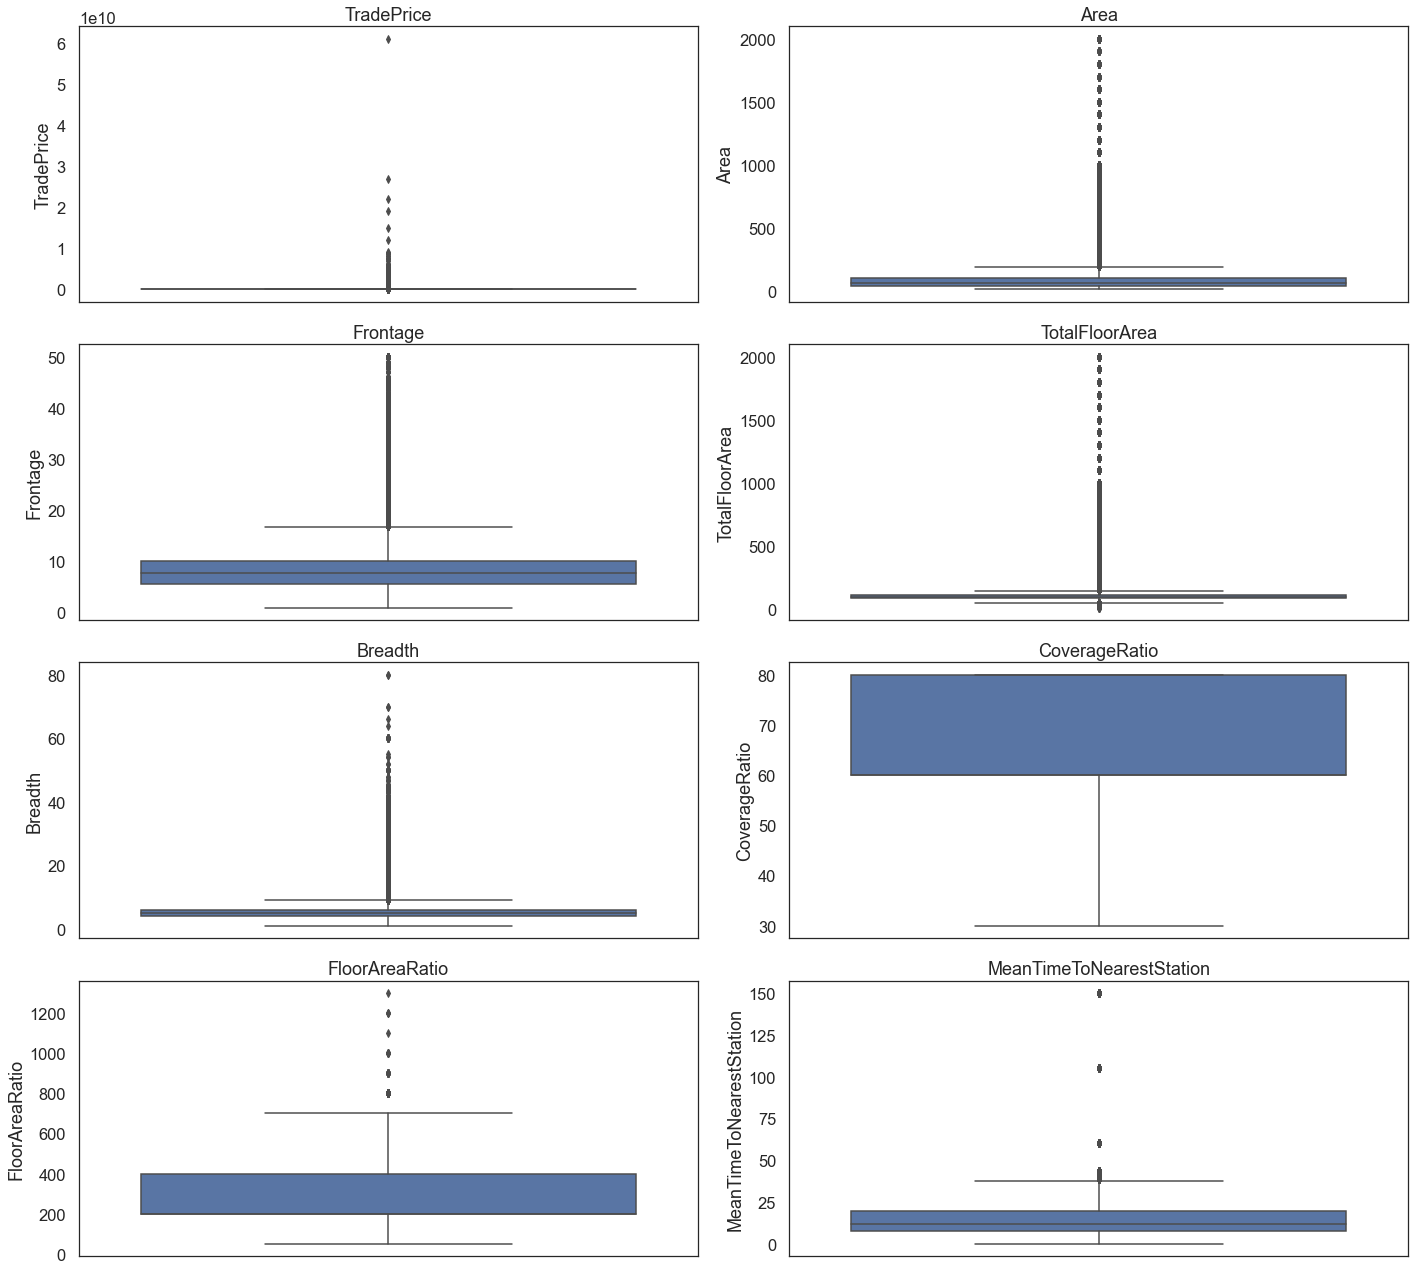

In [17]:
total = len(num_list)
nrows = 4
ncols = math.ceil(total/nrows)
        
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 18))

axs = axs.ravel()

for i in range(total):
    
    sns.boxplot(y=df_tokyo[num_list[i]], ax=axs[i]);
    axs[i].set_title(num_list[i])
    
fig.tight_layout()


plt.show()

### Collect the columns that are numerical and plot the distributions

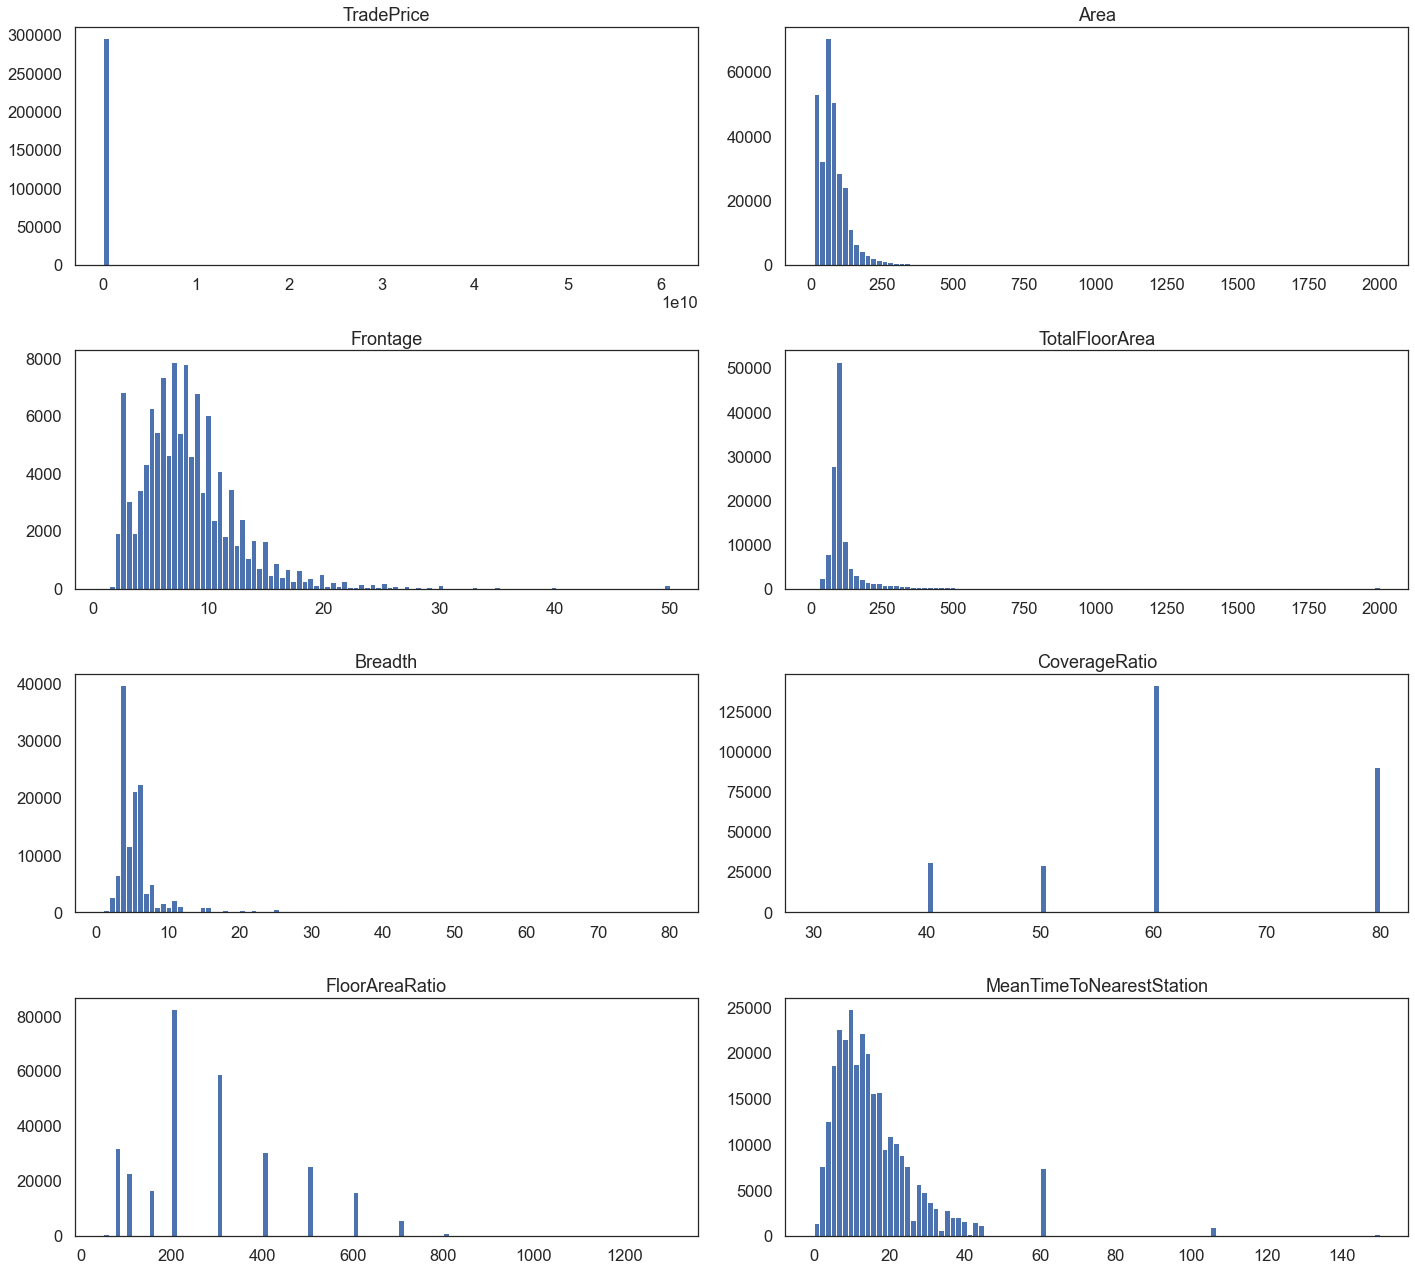

In [18]:
total = len(num_list)
nrows = 4
ncols = math.ceil(total/nrows)
        
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 18))

axs = axs.ravel()

for i in range(total):
    
    axs[i].hist(df_tokyo[num_list[i]], bins=100)
    axs[i].set_title(num_list[i])
    
fig.tight_layout()

### Plot scatter plot between x variables and y variable

In [19]:
def scatter_plot(data, x_variable, y_variable):
    
    sns.lmplot(x=x_variable, y=y_variable, data=data, fit_reg=False)
    plt.title(f'{x_variable} and {y_variable}')
    plt.show()

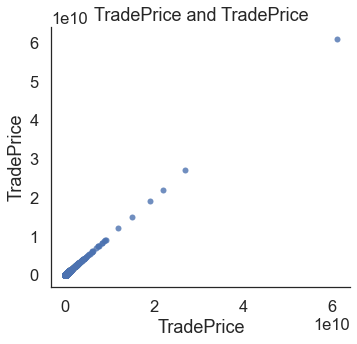

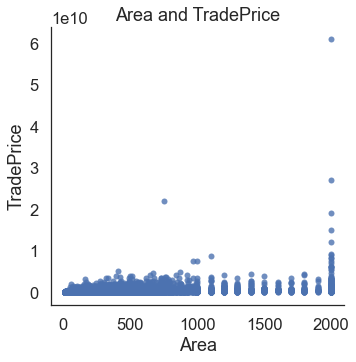

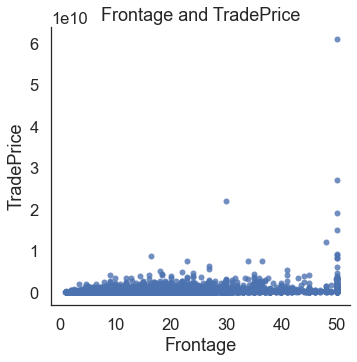

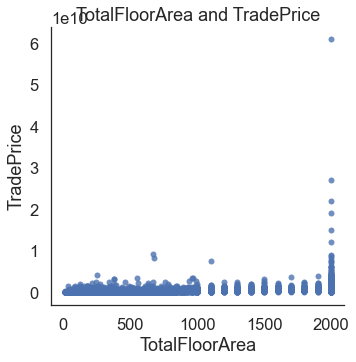

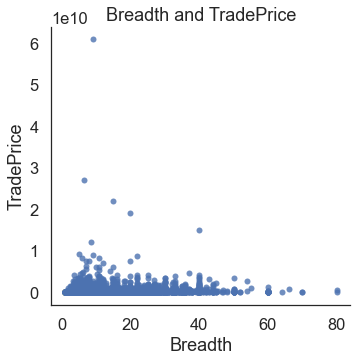

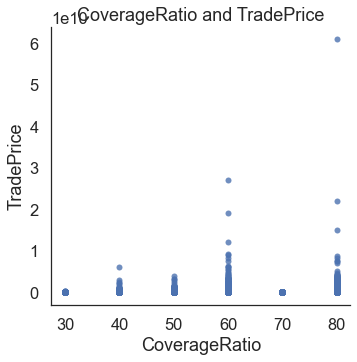

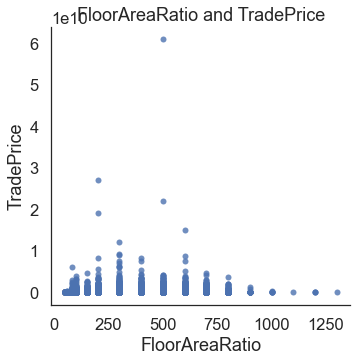

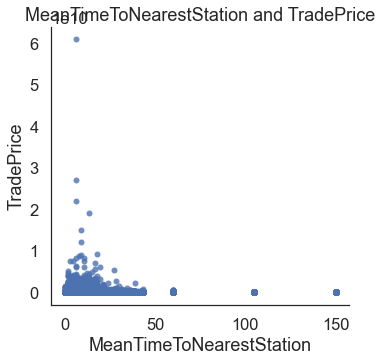

In [20]:
for x_variable in num_list:
    
    scatter_plot(data=df_tokyo, x_variable=x_variable, y_variable='TradePrice')

<b>Conclusion from the scatter plots:</b>

The trade price does not depend only on a single variable.

### Collect the categorical columns and check the frequency of each category

In [21]:
all_var = list(df_tokyo.columns)
cat_list = [x for x in all_var if x not in num_list]
    
for variable in cat_list:
    
    display(df_tokyo[variable].value_counts().rename_axis(variable).reset_index(name='freq'))

,Type,freq
0,"Pre-owned Condominiums, etc.",170694
1,Residential Land(Land and Building),126044


,Region,freq
0,Residential Area,117303
1,Commercial Area,8560
2,Industrial Area,178
3,Potential Residential Area,3


,MunicipalityCode,freq
0,13112,17953
1,13111,17010
2,13120,16528
3,13121,13373
4,13115,12920
5,13119,12296
6,13108,12064
7,13104,11138
8,13109,10522
9,13201,10516


,DistrictName,freq
0,Honcho,1916
1,Kameido,1780
2,Chuo,1749
3,Nishigotanda,1253
4,Nishishinjuku,1226
...,...,...
1409,Hembori,1
1410,Takatsukimachi,1
1411,Kandamatsunagacho,1
1412,Yokosawa,1


,NearestStation,freq
0,Hachioji,2487
1,Shinkoiwa,2349
2,Oizumigakuen,2331
3,Kanamachi,1841
4,Omori (Tokyo),1765
...,...,...
647,Higashiikebukuro 4-chome,1
648,Musashikosugi,1
649,Urayasu (Chiba),1
650,Ryutsu Center,1


,FloorPlan,freq
0,3LDK,46913
1,1K,46021
2,2LDK,29197
3,1LDK,13050
4,1DK,8852
5,2DK,7641
6,4LDK,5009
7,1R,3107
8,3DK,2628
9,2LDK+S,1050


,LandShape,freq
0,Semi-rectangular Shaped,43479
1,Rectangular Shaped,30799
2,Irregular Shaped,19428
3,Semi-trapezoidal Shaped,9232
4,Semi-square Shaped,6480
5,Flag-shaped etc.,6204
6,Semi-shaped,4873
7,Trapezoidal Shaped,4535
8,Square Shaped,894


,BuildingYear,freq
0,2007.0,12265
1,2006.0,11758
2,2005.0,11277
3,2008.0,11246
4,2009.0,9917
...,...,...
71,1950.0,49
72,1949.0,40
73,1948.0,34
74,2020.0,32


,Structure,freq
0,RC,123560
1,W,104729
2,SRC,52918
3,S,8879
4,LS,2994
5,"RC, W",724
6,"S, W",158
7,"SRC, RC",134
8,B,106
9,"RC, S",98


,Use,freq
0,House,273822
1,Housing Complex,11784
2,"House, Shop",2429
3,"Housing Complex, Shop",1579
4,"House, Office",831
...,...,...
129,"Housing Complex, Office, Workshop, Warehouse, ...",1
130,"Housing Complex, Workshop, Parking Lot",1
131,"Housing Complex, Parking Lot, Shop, Other",1
132,"House, Housing Complex, Warehouse, Shop, Other",1


,Purpose,freq
0,Unknown,180895
1,House,107623
2,Other,8220


,Direction,freq
0,South,19812
1,North,19478
2,East,18709
3,West,18405
4,Southeast,12485
5,Southwest,12399
6,Northwest,12391
7,Northeast,11437
8,No facing road,776


,Classification,freq
0,Ward Road,49142
1,Private Road,35251
2,City Road,31205
3,Tokyo Metropolitan Road,3839
4,Road,3713
5,Town Road,617
6,National Highway,575
7,Access Road,427
8,Village Road,158
9,Prefectural Road,62


,CityPlanning,freq
0,Category I Exclusively Low-story Residential Zone,64415
1,Commercial Zone,57480
2,Quasi-industrial Zone,43974
3,Category I Exclusively Medium-high Residential...,42434
4,Category I Residential Zone,31423
5,Neighborhood Commercial Zone,29226
6,Category II Exclusively Medium-high Residentia...,7229
7,Category II Residential Zone,6798
8,Industrial Zone,4307
9,Quasi-residential Zone,4244


,Year,freq
0,2013,25542
1,2016,25239
2,2015,25073
3,2014,23823
4,2010,22900
5,2012,22337
6,2017,21755
7,2011,21225
8,2009,20361
9,2018,19557


,Quarter,freq
0,3,75435
1,1,75413
2,4,73227
3,2,72663


,Renovation,freq
0,Not yet,114577
1,Done,40356


## Data Cleaning

Dropping rare features simplifies your model, but obviously gives you fewer features to work with. Before dropping features outright, consider subsetting the part of the dataset that this value is available for and checking its feature importance when it is used to train a model in this subset. If in doing so you disover that the variable is important in the subset it is defined, consider making an effort to retain it.

Reference: https://www.kaggle.com/residentmario/simple-techniques-for-missing-data-imputation

In [22]:
print('Percentage of null in each column:')
round(df_tokyo.isnull().sum()/len(df_tokyo)*100,2)

Percentage of null in each column:


Type                         0.00
Region                      57.52
MunicipalityCode             0.00
DistrictName                 0.05
NearestStation               0.17
TradePrice                   0.00
FloorPlan                   44.23
Area                         0.00
LandShape                   57.56
Frontage                    61.20
TotalFloorArea              58.01
BuildingYear                 2.19
Structure                    0.80
Use                          0.00
Purpose                      0.00
Direction                   57.57
Classification              57.84
Breadth                     58.03
CityPlanning                 0.92
CoverageRatio                1.35
FloorAreaRatio               1.35
Year                         0.00
Quarter                      0.00
Renovation                  47.79
MeanTimeToNearestStation     2.95
dtype: float64

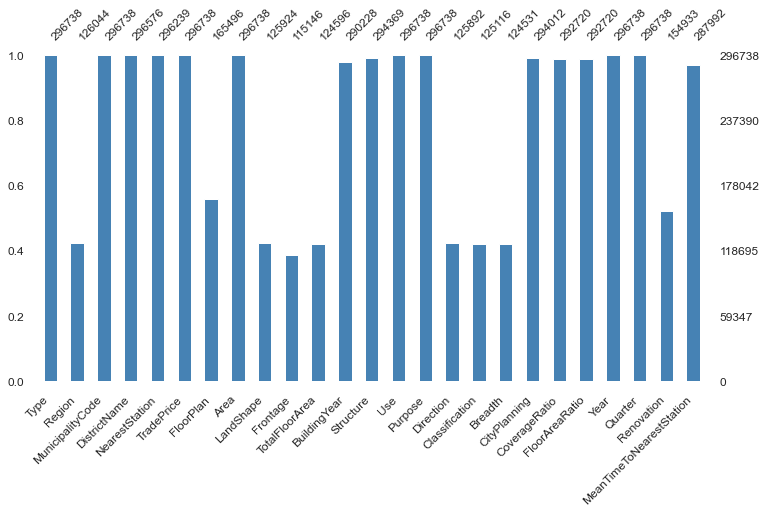

In [23]:
msno.bar(df_tokyo, figsize=(12, 6), fontsize=12, color='steelblue')

plt.show()

### Data Imputation for categorical variables

1. Mode is one of the option.
2. Missing values can be treated as a separate category by itself. We can create another category for the missing values and use them as a different level.
3. If the number of missing values are lesser compared to the number of samples and also the total number of samples is high, we can also choose to remove those rows in our analysis.
4. We can also try to do an imputation based on the values of other variables in the given dataset. We can identify related rows to the given row and then use them for imputation.
5. We can also run a model to predict the missing values using all other variables as inputs.

Reference: https://discuss.analyticsvidhya.com/t/how-to-impute-missing-values-for-a-variable-like-gender/7115

<b>Decision:</b>

1. Since BuildingYear has only 2.19% missing rate, decided to use mode for the imputation.
2. Since it is not our main focus here and for the sake of simplicity, I will just impute unknown as the nan class for other categorical variables.

In [24]:
df_tokyo.loc[df_tokyo['BuildingYear'].isna(), 'BuildingYear'] = df_tokyo['BuildingYear'].mode().values[0]

In [25]:
missing_cat_columns = ['Region', 'NearestStation', 'DistrictName', 'NearestStation', 
                       'FloorPlan', 'LandShape', 'Structure', 'Direction', 'Classification',
                       'CityPlanning', 'Renovation']

for variable in missing_cat_columns:

    df_tokyo[variable].fillna('Unknown', inplace=True)

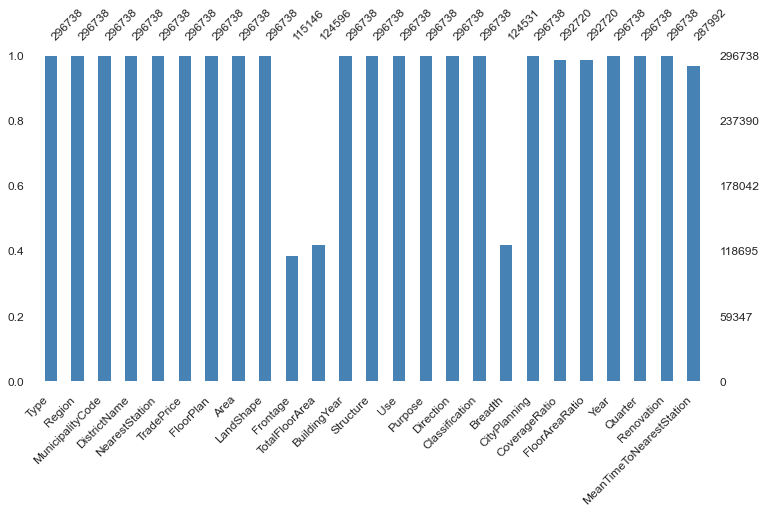

In [26]:
msno.bar(df_tokyo, figsize=(12, 6), fontsize=12, color='steelblue')

plt.show()

In [27]:
df_tokyo_ = df_tokyo.copy()

### Target encode categorical data

In [28]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target encoder.
    
    Replaces categorical column(s) with the mean target value for
    each category.

    """
    
    def __init__(self, cols=None):
        """Target encoder
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.  Default is to target 
            encode all categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X]

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

In [29]:
all_x_var = list(df_tokyo_.columns)
all_x_var.remove('TradePrice')

num_list = ['Area','Frontage','TotalFloorArea','Breadth',
            'CoverageRatio','FloorAreaRatio','MeanTimeToNearestStation', 'Year']

cat_list = [x for x in all_x_var if x not in num_list]

y_data = df_tokyo_['TradePrice']

num_x_data = df_tokyo_[num_list]
cat_x_data = df_tokyo_[cat_list]

In [30]:
te = TargetEncoder()
encoded_x_data = te.fit_transform(cat_x_data, y_data)

In [31]:
df_tokyo_encoded = pd.merge(encoded_x_data, num_x_data, left_index=True, right_index=True)
df_tokyo_encoded = pd.merge(df_tokyo_encoded, y_data, left_index=True, right_index=True)

### Data Imputation for numerical variables

In [32]:
all_variables = list(df_tokyo_encoded.columns)

In [33]:
# calling the  MICE class 
mice_imputer = IterativeImputer(min_value=0) 
# imputing the missing value with mice imputer 
df_tokyo_output = mice_imputer.fit_transform(df_tokyo_encoded) 

In [34]:
df_tokyo_ = pd.DataFrame(df_tokyo_output, columns=all_variables)

In [35]:
df_tokyo_.head()

,Type,Region,MunicipalityCode,DistrictName,NearestStation,FloorPlan,LandShape,BuildingYear,Structure,Use,Purpose,Direction,Classification,CityPlanning,Quarter,Renovation,Area,Frontage,TotalFloorArea,Breadth,CoverageRatio,FloorAreaRatio,MeanTimeToNearestStation,Year,TradePrice
0,3.069217e+07,3.069217e+07,8.099496e+07,57693750.0,5.092391e+07,3.513731e+07,3.070827e+07,4.814268e+07,4.886580e+07,3.684510e+07,4.820464e+07,3.070091e+07,3.064848e+07,4.913333e+07,4.744492e+07,3.146724e+07,30.0,0.601224,534.801377,1.014995,80.0,500.0,6.0,2019.0,40000000.0
1,7.093609e+07,2.133099e+08,8.099496e+07,57693750.0,5.092391e+07,6.928304e+07,6.260606e+07,3.473787e+07,4.886580e+07,2.253968e+08,4.693176e+07,8.139204e+07,1.726076e+08,4.913333e+07,4.566145e+07,6.611977e+07,50.0,5.200000,260.000000,27.000000,80.0,700.0,1.5,2019.0,180000000.0
2,3.069217e+07,3.069217e+07,8.099496e+07,57693750.0,5.092391e+07,4.177244e+07,3.070827e+07,5.246923e+07,4.886580e+07,3.684510e+07,4.820464e+07,3.070091e+07,3.064848e+07,4.913333e+07,4.566145e+07,2.969823e+07,65.0,1.947433,628.929468,0.222661,80.0,500.0,6.0,2019.0,100000000.0
3,3.069217e+07,3.069217e+07,8.099496e+07,57693750.0,5.092391e+07,3.513731e+07,3.070827e+07,3.658463e+07,3.841949e+07,3.684510e+07,4.820464e+07,3.070091e+07,3.064848e+07,4.913333e+07,4.822598e+07,3.146724e+07,35.0,0.427417,612.788617,2.298573,80.0,700.0,4.5,2018.0,24000000.0
4,3.069217e+07,3.069217e+07,8.099496e+07,57693750.0,5.092391e+07,3.918859e+07,3.070827e+07,5.246923e+07,4.886580e+07,3.684510e+07,6.111792e+07,3.070091e+07,3.064848e+07,4.913333e+07,4.566145e+07,3.146724e+07,70.0,2.420482,576.650531,0.307518,80.0,500.0,6.0,2018.0,81000000.0


In [36]:
num_list = ['TradePrice','Area','Frontage','TotalFloorArea','Breadth',
            'CoverageRatio','FloorAreaRatio','MeanTimeToNearestStation']

df_tokyo_[num_list].describe()

,TradePrice,Area,Frontage,TotalFloorArea,Breadth,CoverageRatio,FloorAreaRatio,MeanTimeToNearestStation
count,2.967380e+05,296738.000000,296738.000000,296738.000000,296738.000000,296738.000000,296738.000000,296738.000000
mean,4.778639e+07,83.071834,4.649803,306.436924,3.992782,62.998177,276.887439,15.282767
std,1.762832e+08,97.340440,4.639685,217.212054,3.256129,12.915815,158.985678,12.753006
min,1.200000e+03,10.000000,0.000000,0.000000,0.000000,30.000000,0.000000,0.000000
25%,2.100000e+07,40.000000,1.504889,95.000000,2.113916,60.000000,200.000000,7.500000
50%,3.300000e+07,65.000000,3.267803,310.790970,3.807684,60.000000,200.000000,12.000000
75%,4.900000e+07,100.000000,7.000000,474.262421,5.000000,80.000000,400.000000,19.500000
max,6.100000e+10,2000.000000,72.043749,2076.312029,80.000000,80.677229,1300.000000,150.000000


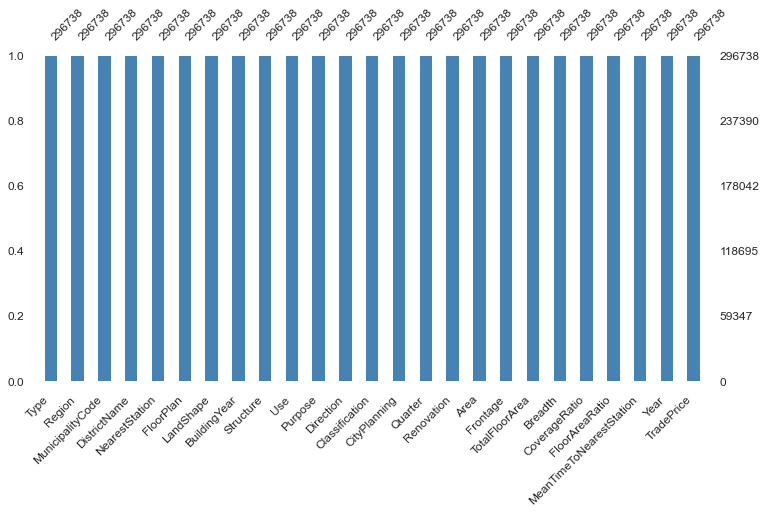

In [37]:
msno.bar(df_tokyo_, figsize=(12, 6), fontsize=12, color='steelblue')

plt.show()

In [38]:
np.sort(df_tokyo_['Year'].unique())

array([2005., 2006., 2007., 2008., 2009., 2010., 2011., 2012., 2013.,
       2014., 2015., 2016., 2017., 2018., 2019.])

# Start

## To Detect Covariate Shift

### Split dataset into train test set

- Train set: 2005~2018
- Test set: 2019

In [39]:
X_train = df_tokyo_[df_tokyo_['Year']!=2019]
y_train = X_train['TradePrice']
X_train.drop('TradePrice', axis=1, inplace=True)

X_test = df_tokyo_[df_tokyo_['Year']==2019]
y_test = X_test['TradePrice']
X_test.drop('TradePrice', axis=1, inplace=True)

/Users/khor.eanyee/miniconda3/envs/shift/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/khor.eanyee/miniconda3/envs/shift/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [40]:
RANDOM_STATE = 0

In [41]:
def detect_covariate_shift(df_train, df_test, threshold=0.8, random_state=0):
    
    ## Step 1: Create a new variable called ‘is_train’ with value of one in the train set and zero in the test test.
    df_train['is_train'] = 1
    df_test['is_train'] = 0
    
    ## Select samples if the size of data is too large
    if len(df_train)>10000:
        df_train = df_train.sample(7000, random_state=random_state)
        
    if len(df_test)>10000:
        df_test = df_test.sample(6000, random_state=random_state)
        
    ## Step 2: Combine train and test sets and shuffle them randomly.
    combined_set = df_train.append(df_test)
    y_label = combined_set['is_train']
    combined_set.drop('is_train',axis=1,inplace=True)
    
    ## Step 3: Modelling
    rfc = RandomForestClassifier(random_state=random_state)
    drop_list = []
    for feature in combined_set.columns:
        score = cross_val_score(estimator=rfc, X=pd.DataFrame(combined_set[feature]), y=y_label, cv=3, scoring='roc_auc')
        
        print(f'{feature}: {np.mean(score)}')
        
        if (np.mean(score)>threshold):
            
            drop_list.append(feature)
        
    return drop_list

In [42]:
drop_list = detect_covariate_shift(df_train=X_train, df_test=X_test, threshold=0.65, random_state=RANDOM_STATE)

/Users/khor.eanyee/miniconda3/envs/shift/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/khor.eanyee/miniconda3/envs/shift/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Type: 0.5073347938186298
Region: 0.5056402822205106
MunicipalityCode: 0.5325154149209466
DistrictName: 0.5318827868113856
NearestStation: 0.5213376028868367
FloorPlan: 0.5284666741778388
LandShape: 0.5244394306451907
BuildingYear: 0.6406154400438893
Structure: 0.520593520199911
Use: 0.5106515720112054
Purpose: 0.7877765594007614
Direction: 0.5029210162903673
Classification: 0.4996818524264637
CityPlanning: 0.5273562415667656
Quarter: 0.6864560422421713
Renovation: 0.5030489233955935
Area: 0.515737608249336
Frontage: 0.5177407542184077
TotalFloorArea: 0.5002208134183204
Breadth: 0.5110803986963249
CoverageRatio: 0.526765156697621
FloorAreaRatio: 0.5210910755490471
MeanTimeToNearestStation: 0.5260390488670619
Year: 1.0


In [43]:
drop_list

['Purpose', 'Quarter', 'Year']

## Model Training

### Perform Train Test Split

In this section, two different train sets are used and compared:

1. Year 2015~2018 all features.
2. Year 2015~2018 all features except 'Purpose', 'Quarter', and 'Year.

In [44]:
train_data_all = df_tokyo[df_tokyo['Year']<2019]
test_data = df_tokyo[df_tokyo['Year']==2019]

features_all = list(df_tokyo.columns)
features_all.remove('TradePrice')

features_dropped = list(set(list(df_tokyo.columns)) - set(drop_list))
features_dropped.remove('TradePrice')

y_train = train_data_all['TradePrice']
y_test = test_data['TradePrice']

X_train_all = train_data_all[features_all]
X_test_all = test_data[features_all]

X_train_dropped = train_data_all[features_dropped]
X_test_dropped = test_data[features_dropped]

## Baseline

For comparison, how well would we do if we just predicted the mean target value for all samples? We’ll use the mean absolute error (MAE) as our performance metric.

In [45]:
test_mae_baseline = mean_absolute_error(y_test, np.full(y_test.shape[0], y_test.mean()))
test_mae_baseline

34899644.89435042

In [46]:
# Regression model
linear_regression = Pipeline([
    ('encoder', TargetEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', IterativeImputer(min_value=0)),
    ('regressor', LinearRegression())
])

# Cross-validated MAE
mae_scorer = make_scorer(mean_squared_error)
lr_all_scores = cross_val_score(linear_regression, X_train_all, y_train, 
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE: %0.3f +/- %0.3f'
      % (lr_all_scores.mean(), lr_all_scores.std()))

# MAE on test data
linear_regression.fit(X_train_all, y_train)
y_pred = linear_regression.predict(X_test_all)
test_mae_all = mean_absolute_error(y_test, y_pred)
print('Test MAE: %0.3f' % test_mae_all)

Cross-validated MAE: 27869589159034380.000 +/- 23028559799992144.000
Test MAE: 24568366.981


In [47]:
# Regression model
linear_regression = Pipeline([
    ('encoder', TargetEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', IterativeImputer(min_value=0)),
    ('regressor', LinearRegression())
])

# Cross-validated MAE
mae_scorer = make_scorer(mean_squared_error)
lr_all_scores = cross_val_score(linear_regression, X_train_dropped, y_train, 
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE: %0.3f +/- %0.3f'
      % (lr_all_scores.mean(), lr_all_scores.std()))

# MAE on test data
linear_regression.fit(X_train_dropped, y_train)
y_pred = linear_regression.predict(X_test_dropped)
test_mae_dropped = mean_absolute_error(y_test, y_pred)
print('Test MAE: %0.3f' % test_mae_dropped)

Cross-validated MAE: 27879686784524948.000 +/- 23027718913615724.000
Test MAE: 24392867.968


## Conclusion

Removed shifted feature helps to reduce the MAE.

## To Detect Prior Probability Shift

### Split dataset into train test set

- Train set: 2005~2018
- Test set: 2019

In [48]:
X_train = df_tokyo_[df_tokyo_['Year']!=2019]
y_train = X_train['TradePrice']
X_train.drop('TradePrice', axis=1, inplace=True)

X_test = df_tokyo_[df_tokyo_['Year']==2019]
y_test = X_test['TradePrice']
X_test.drop('TradePrice', axis=1, inplace=True)

/Users/khor.eanyee/miniconda3/envs/shift/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/khor.eanyee/miniconda3/envs/shift/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [49]:
# student's t-test
def prior_proba_shift(y_train, y_test):
    
    # compare samples
    stat, p_value = ttest_ind(y_train, y_test)
    print('Statistics=%.3f, p=%.3f' % (stat, p_value))
    # interpret
    alpha = 0.05
    if p_value > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')
    
    plt.figure(figsize=(8,5))

    plt.hist(x=y_train, bins=50, color='steelblue', alpha=0.5)
    plt.hist(x=y_test, bins=50, color='lightcoral', alpha=0.5)
    
    plt.xlabel('Trade Price', fontsize=14)
    plt.ylabel('Total Number', fontsize=14)
    plt.title('Distribution between Train and Test Data', fontsize=16)

    plt.show()

Statistics=-3.245, p=0.001
Different distributions (reject H0)


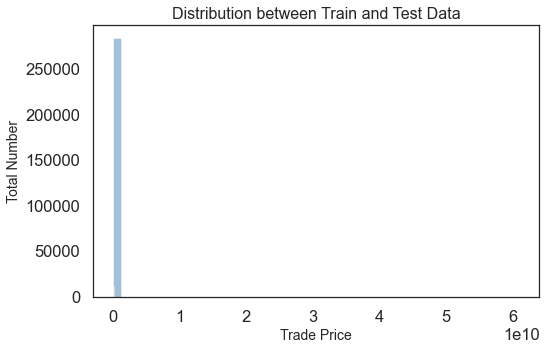

In [50]:
prior_proba_shift(y_train, y_test)

## Conclusion

In general, the prior probability shift has occurred from T-test analysis.

Now, let's see which year has same distribution to TradePrice of 2019.

In [51]:
# student's t-test
year_list = range(2009, 2019)

for year in year_list:

    # compare samples
    stat, p = ttest_ind(df_tokyo_[df_tokyo_['Year']==2019]['TradePrice'], df_tokyo_[df_tokyo_['Year']==year]['TradePrice'])

    print('2019 vs %.0f: Statistics=%.3f, p=%.3f' % (year, stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')

2019 vs 2009: Statistics=8.902, p=0.000
Different distributions (reject H0)
2019 vs 2010: Statistics=6.099, p=0.000
Different distributions (reject H0)
2019 vs 2011: Statistics=1.967, p=0.049
Different distributions (reject H0)
2019 vs 2012: Statistics=9.246, p=0.000
Different distributions (reject H0)
2019 vs 2013: Statistics=9.017, p=0.000
Different distributions (reject H0)
2019 vs 2014: Statistics=6.405, p=0.000
Different distributions (reject H0)
2019 vs 2015: Statistics=6.193, p=0.000
Different distributions (reject H0)
2019 vs 2016: Statistics=3.353, p=0.001
Different distributions (reject H0)
2019 vs 2017: Statistics=1.430, p=0.153
Same distributions (fail to reject H0)
2019 vs 2018: Statistics=-2.012, p=0.044
Different distributions (reject H0)


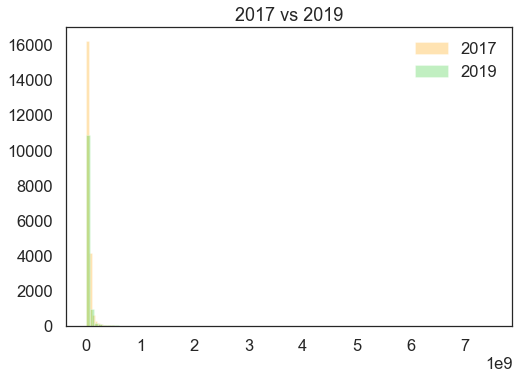

In [52]:
year1 = 2017
year2 = 2019

plt.hist(df_tokyo_[df_tokyo_['Year']==year1]['TradePrice'], bins=100, alpha=0.3, color='orange', label=f'{year1}')
plt.hist(df_tokyo_[df_tokyo_['Year']==year2]['TradePrice'], bins=100, alpha=0.3, color='limegreen', label=f'{year2}')

plt.title(f'{year1} vs {year2}')

plt.legend()

plt.show()

## Conclusion

From T-test analysis, only 2017 TradePrice has the same distribution to 2019 Trade Price.

In this section, three different train sets are used and compared:

1. Year 2015~2018 all features except 'Purpose', 'Quarter', and 'Year.
2. Year 2017 all features except 'Purpose', 'Quarter', and 'Year.
2. Year 2018 all features except 'Purpose', 'Quarter', and 'Year.

In [53]:
train_data_all_years = df_tokyo[df_tokyo['Year']<2019]
train_data_2017 = df_tokyo[df_tokyo['Year']==2017]
train_data_2018 = df_tokyo[df_tokyo['Year']==2018]
test_data = df_tokyo[df_tokyo['Year']==2019]

y_train_all_years = train_data_all_years['TradePrice']
y_train_2017 = train_data_2017['TradePrice']
y_train_2018 = train_data_2018['TradePrice']
y_test = test_data['TradePrice']

X_train_all_years = train_data_all_years[features_dropped]
X_train_2017 = train_data_2017[features_dropped]
X_train_2018 = train_data_2018[features_dropped]
X_test = test_data[features_dropped]

## Train Linear Regression Model with only 2017 or 2018 data.

Reason: Only 2017 TradePrice has the same distribution to 2019 Trade Price. I am curious what is the effect of only including 2017 data as train data and also the effect of only including 2018 as train data.

In [54]:
# Regression model
linear_regression = Pipeline([
    ('encoder', TargetEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', IterativeImputer(min_value=0)),
    ('regressor', LinearRegression())
])

# Cross-validated MAE
mae_scorer = make_scorer(mean_squared_error)
lr_all_scores = cross_val_score(linear_regression, X_train_2017, y_train_2017, 
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE: %0.3f +/- %0.3f'
      % (lr_all_scores.mean(), lr_all_scores.std()))

# MAE on test data
linear_regression.fit(X_train_2017, y_train_2017)
y_pred = linear_regression.predict(X_test)
test_mae_2017 = mean_absolute_error(y_test, y_pred)
print('Test MAE: %0.3f' % test_mae_2017)

Cross-validated MAE: 5342523357402623.000 +/- 3182786104754068.500
Test MAE: 21536265.401


In [55]:
# Regression model
linear_regression = Pipeline([
    ('encoder', TargetEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', IterativeImputer(min_value=0)),
    ('regressor', LinearRegression())
])

# Cross-validated MAE
mae_scorer = make_scorer(mean_squared_error)
lr_all_scores = cross_val_score(linear_regression, X_train_2018, y_train_2018, 
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE: %0.3f +/- %0.3f'
      % (lr_all_scores.mean(), lr_all_scores.std()))

# MAE on test data
linear_regression.fit(X_train_2018, y_train_2018)
y_pred = linear_regression.predict(X_test)
test_mae_2018 = mean_absolute_error(y_test, y_pred)
print('Test MAE: %0.3f' % test_mae_2018)

Cross-validated MAE: 171287527412370112.000 +/- 156198141757435808.000
Test MAE: 32963669.776


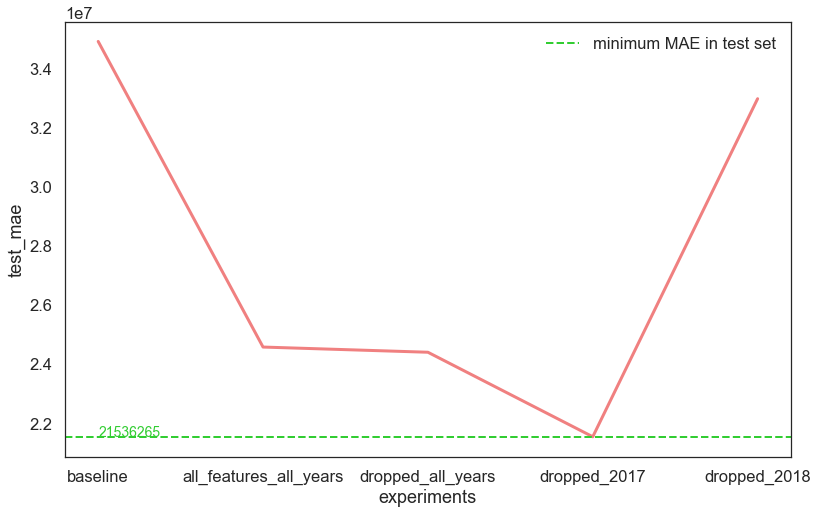

In [56]:
experiments = ['baseline', 'all_features_all_years', 'dropped_all_years', 'dropped_2017', 'dropped_2018']

sns.set(font_scale = 1.5)
sns.set_style('white')

plt.figure(figsize=(13,8))

test_maes = [test_mae_baseline, test_mae_all, test_mae_dropped, test_mae_2017, test_mae_2018]

min_mae = int(min(test_maes))

df_test_maes = pd.DataFrame(list(zip(experiments, test_maes)), 
                            columns =['experiments', 'test_mae'])

sns.lineplot(x='experiments', y='test_mae', data=df_test_maes, linewidth = 3, 
             sort=False, color='lightcoral')

plt.axhline(y=min_mae, label='minimum MAE in test set', color='limegreen', linewidth = 2, linestyle='--')
plt.text(0, min_mae, str(min_mae), label='min mae', color='limegreen', fontsize=14)

plt.legend()

plt.show()

## Conclusion

As obtained from the result, train with only 2017 year data and all features except 'Purpose', 'Quarter', and 'Year (as indicated as dropped in the graph above) has the best result. 

Hence, large train data do not imply for getting a good result. Instead, good quality data is the key to get a good model.

However, this notebook is just used for illustration of the effect of prior probability shift. In reality, we cannot know the distribution of y_test.

---

## Reference

https://www.analyticsvidhya.com/blog/2017/07/covariate-shift-the-hidden-problem-of-real-world-data-science/